# Imports & Constants

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import ast
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import random
import seaborn as sns
import statsmodels.api as sm

In [4]:
from random import choices
from scipy import stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning
from tqdm.notebook import tqdm
from matplotlib.colors import ListedColormap

In [5]:
from jupyter_utils import style, mean_std, display_test, display_group_test, \
    scatter_annotate, show_corrtest_mask_corr, pointplot, pointplot_horizontal, add_grey, \
    prep_horizontal_pointplot_errobar_data, pointplot_horizontal_wo_errorbar, map_model, prep_LM_pointplot, draw_sample_with_replacement, t_test
from ortogonolize_utils import compute_coefficient

In [6]:
import warnings
warnings.filterwarnings(action='ignore', category=np.VisibleDeprecationWarning)
warnings.filterwarnings(action='ignore', message='All-NaN slice encountered')
warnings.filterwarnings(action='ignore', message='Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.')
warnings.filterwarnings(action='ignore', message='Mean of empty slice')
warnings.filterwarnings(action='ignore', category=stats.ConstantInputWarning)
warnings.filterwarnings(action="ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)
warnings.filterwarnings(action="ignore", category=HessianInversionWarning)

In [7]:
sns.set_theme(style="whitegrid")

In [8]:
PATH = '/Users/galina.ryazanskaya/Downloads/thesis?/code?/'

In [9]:
PATH_FIG = '/Users/galina.ryazanskaya/Downloads/thesis?/figures/ru/'

1. mean sent len vs sent count vs word count
- is word count a good baseline?
- do other metrics correlate with it more than with mean sent len / sent count?

each group of metrcis:
- contorol:
    - 3 (2 * 2) panel correlation w control

- t:
    - each task:
        - 3 * 2 pannel (corr: mean sent len vs sent count vs word count     +     3 * t-test)
        - line for each baseline on the respective t-test panel?
    - cross-task comparison:
        - average?
        - (2 * 2) panel t-test

- r:
    - each task:
        - 3 * 3 pannel (corr: mean sent len vs sent count vs word count)    +    (6-panel scales)
        - each scale pannel has all the three baseline lines?
    - cross-task comparison:
        - average?
        - (2 * 2) panel for each scale


2. cross group metric comparison
- no filtering out based on the control correlation, only based on the performance
- the ones that correlate with some control above the threshold, make the marker different in the comparison

# Load data

In [10]:
merge_df = pd.read_csv('/Users/galina.ryazanskaya/Downloads/thesis?/code?/processed_values/ru_all.csv', index_col=0, header=[0, 1, 2])

In [11]:
TASKS = ['adventure', 'chair', 'present', 'sportsman']

In [12]:
scale_cols = [('target', x) for x in ['panss_pos', 'panss_neg', 'panss_o', 'panss_total']]

In [13]:
cols_tasks = merge_df['sportsman'].columns
cols_LM = [col for col in merge_df['sportsman'] if col[0] == 'LM']
cols_synt = [col for col in merge_df['sportsman'] if col[0] == 'syntactic']
cols_lex = [col for col in merge_df['sportsman'] if col[0] == 'lexical']
cols_graph = [col for col in merge_df['sportsman'] if col[0] == 'graph']

In [14]:
def task_data(df, task, keep_target=True, fill_synt=True):
    subset = df[task].dropna(axis=0, how='all')
    if fill_synt:
        subset['syntactic'] = subset['syntactic'].fillna(0.0)   # fills NAs in missing POS
    if keep_target:
        subset = pd.concat([subset, df['target'].loc[subset.index]], axis=1)
    return subset

In [15]:
def aplly_to_all_tasks(df, f, tasks=TASKS, to_df=True, *args, **kwargs):
    res = {}
    for task in tasks:
        data = task_data(df, task)
        res[task] = f(data, *args, **kwargs)
    if to_df:
        if all(isinstance(v, pd.Series) for v in res.values()):
            return pd.DataFrame(res)
        elif all(isinstance(v, pd.DataFrame) for v in res.values()):
            return pd.concat(list(res.values()), keys=list(res.keys()), names=['task'], axis=1)
        else:
            return res
    return res

# Bootstrap

In [16]:
def compute_pseudo_rsquared_ordered(df, target_col, predictor_cols):
    df = df.loc[df[[target_col] + predictor_cols].dropna().index]
    mod_prob = OrderedModel(df[target_col],
                        df[predictor_cols],
                        distr='probit')

    res_prob = mod_prob.fit(method='bfgs', disp=0)
    return res_prob.prsquared

In [17]:
a = 0.05

In [18]:
def ttest_select(df, test_two_groups, colname, cols_tasks=cols_tasks):
    groups = df[df[('target', colname)].isin(test_two_groups)]
    s_t, res_t = display_group_test(groups, cols_tasks, ('target', colname), test=stats.ttest_ind, stat_name='t', alpha=a)
    return res_t['t']

In [19]:
cols_to_correct_for = [('syntactic', 'mean_sent_len'), ('syntactic', 'n_sents'), ('lexical', 'n_words')]

In [20]:
def bootstrap_with_corrections(df, cols_av, scale_cols, N, columns_to_correct_for=cols_to_correct_for, group=None, 
             ordered_tgt=[('target', 'dep.severity'), ('target', 'td.severity')]):
    o_tgt = tuple((f'ps_r_{o[1]}' for o in ordered_tgt))
    correction_corr_names = tuple(f'r_corr_w_{x[-1]}' for x in columns_to_correct_for)
    res_c = ('sample_raw', 'r', 't') + correction_corr_names + o_tgt
    dict_scales_sapmles = {k: {scale: {metric: [] for metric in cols_av} for scale in scale_cols} for k in res_c}
    for i in tqdm(range(N)):
        sample = draw_sample_with_replacement(df, seed=i)
        scale_independent = {k: {metric: np.nan for metric in cols_av} for k in ('t',) + correction_corr_names + o_tgt}
        for col in cols_av:
            if group:
                t_test_res = ttest_select(sample, ('sz', 'control_psy'), group)[col]
                scale_independent['t'][col] = t_test_res
            for col_to_correct_for in columns_to_correct_for:
                if col != col_to_correct_for:
                    dropped_c = sample.dropna(subset=[col, col_to_correct_for])
                    r_c = stats.pearsonr(dropped_c[col], dropped_c[col_to_correct_for])[0]
                    scale_independent[f'r_corr_w_{col_to_correct_for[-1]}'][col] = r_c
            for tgt in ordered_tgt:
                ps_r = compute_pseudo_rsquared_ordered(sample, tgt, [col])
                scale_independent[f'ps_r_{tgt[1]}'][col] = ps_r
            for scale in scale_cols:
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
                dropped = sample.dropna(subset=[col, scale])
                r = stats.pearsonr(dropped[col], dropped[scale])[0]
                dict_scales_sapmles['r'][scale][col].append(r)
                
                for k in scale_independent:
                    dict_scales_sapmles[k][scale][col].append(scale_independent[k][col])
                
    return dict_scales_sapmles

**expensive to compute**

In [127]:
# N = 1000
# dict_scales_sapmles = aplly_to_all_tasks(merge_df, bootstrap_with_corrections, cols_av=cols_tasks, scale_cols=scale_cols, N=N, columns_to_correct_for=cols_to_correct_for, group='diagnosis.type')

In [128]:
# reform = {(task, scale[1], measure): dict_scales_sapmles[task][measure][scale] for scale in scale_cols for task in dict_scales_sapmles
#           for measure in dict_scales_sapmles[task]}

In [129]:
# with open('processed_values/ru_task_scales_samples_1000_w_verbosity.pickle', 'wb') as f:
#     pickle.dump(reform, f)

In [21]:
with open('processed_values/ru_task_scales_samples_1000_w_verbosity.pickle', 'rb') as f:
    reform_v = pickle.load(f)

In [22]:
reformed_d_w_verbosity = pd.DataFrame(reform_v)

In [23]:
def bootstrap(df, cols_av, scale_cols, N, col_to_correct_for=('syntactic', 'mean_sent_len'), group=None, 
             ordered_tgt=[('target', 'dep.severity'), ('target', 'td.severity')]):
    o_tgt = tuple((f'ps_r_{o[1]}' for o in ordered_tgt))
    res_c = ('sample_corr', 'sample_raw', 'r', 't', 'r_corr_w_control') + o_tgt
    dict_scales_sapmles = {k: {scale: {metric: [] for metric in cols_av} for scale in scale_cols} for k in res_c}
    for i in tqdm(range(N)):
        sample = draw_sample_with_replacement(df, seed=i)
        scale_independent = {k: {metric: np.nan for metric in cols_av} for k in ('t', 'r_corr_w_control') + o_tgt}
        for col in cols_av:
            if group:
                t_test_res = ttest_select(sample, ('sz', 'control_psy'), group)[col]
                scale_independent['t'][col] = t_test_res
            if col != col_to_correct_for:
                dropped_c = sample.dropna(subset=[col, col_to_correct_for])
                r_c = stats.pearsonr(dropped_c[col], dropped_c[col_to_correct_for])[0]
                scale_independent['r_corr_w_control'][col] = r_c
            for tgt in ordered_tgt:
                ps_r = compute_pseudo_rsquared_ordered(sample, tgt, [col])
                scale_independent[f'ps_r_{tgt[1]}'][col] = ps_r
            for scale in scale_cols:
                r_raw = compute_coefficient(sample, scale, col)[0]
                dict_scales_sapmles['sample_raw'][scale][col].append(r_raw)
                
                dropped = sample.dropna(subset=[col, scale])
                r = stats.pearsonr(dropped[col], dropped[scale])[0]
                dict_scales_sapmles['r'][scale][col].append(r)
                
                for k in scale_independent:
                    dict_scales_sapmles[k][scale][col].append(scale_independent[k][col])
                
    return dict_scales_sapmles

**expensive to compute**

In [133]:
# N = 1000
# dict_scales_sapmles = aplly_to_all_tasks(merge_df, bootstrap, cols_av=cols_tasks, scale_cols=scale_cols, N=N, col_to_correct_for=('syntactic', 'mean_sent_len'), group='diagnosis.type')

In [134]:
# reform = {(task, scale[1], measure): dict_scales_sapmles[task][measure][scale] for scale in scale_cols for task in dict_scales_sapmles
#           for measure in dict_scales_sapmles[task]}

In [135]:
# with open('processed_values/ru_task_scales_samples_1000_wo_o.pickle', 'wb') as f:
#     pickle.dump(reform, f)

In [24]:
with open('processed_values/ru_task_scales_samples_1000_wo_o.pickle', 'rb') as f:
    reform = pickle.load(f)

# Plot & Analyze

In [25]:
reformed_d = pd.DataFrame(reform)

In [26]:
panss_ = ('panss_pos', 'panss_neg', 'panss_o', 'panss_total')
sc_ind_ = ('t', 'r_corr_w_control', 'ps_r_dep.severity', 'ps_r_td.severity')
models_ = ('bert', 'glove_tf', 'glove_avg', 'w2v_tf', 'w2v_avg')
metrics_ = ('cgcoh', 'gcoh', 'lcoh', 'scoh', 'sprob', 'pppl')

In [38]:
panss_order = ['panss_pos', 'panss_neg', 'panss_o', 'panss_total']

In [28]:
order=['bert', 'glove_tf', 'glove_avg', 'w2v_tf', 'w2v_avg']

In [29]:
figprms = {'syntactic': 
               {'subplot_size': (9, 4.5),
                'wspace': 0.25,
                'hspace': 0.125,
                'yt': 0.925
                }, 
           'LM': 
               {'subplot_size': (9, 5.5),
                'wspace': 0.275,
                'hspace': 0.125,
                'yt': 0.925
               }, 
           'lexical': 
               {'subplot_size': (9, 2),
                'wspace': 0.2,
                'hspace': 0.3,
                'yt': 0.95
               }, 
           'graph': 
               {'subplot_size': (9, 3.5), 
                'wspace': 0.3,
                'hspace': 0.15,
                'yt': 0.95
               }}

In [142]:
def get_fparams(m_type, n_sublots_height, n_sublots_width, figparams):
    subplot_size = figprms[m_type]['subplot_size']
    width = subplot_size[0] * n_sublots_width
    height = subplot_size[1] * n_sublots_height
    figsize = (width, height)
    wspace = figprms[m_type]['wspace']
    hspace = figprms[m_type]['hspace']
    yt = figprms[m_type]['yt']
    return figsize, wspace, hspace, yt

### Plot horizontal bar plots

In [143]:
def plot_horizontal_tasks(df, title, scale, measure, xname=None, m_type='syntactic', 
                          plot_abs=False, r=0.3, figparams=figprms):
    absolute_value = f' (absolute r value)' if plot_abs else ''
    figsize, wspace, hspace, yt = get_fparams(m_type, 2, 2, figparams)
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    fig.suptitle(title + absolute_value, y=yt)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    
    axs = axes.flatten()
    
    for i, task in enumerate(TASKS):
        ax = axs[i]
        pointplot_horizontal(prep_horizontal_pointplot_errobar_data(df.loc[m_type, (task, scale)], 
                                                        col=measure, plot_abs=plot_abs), 
                       x=measure, ax=ax)
        ax.set_title(task)

    add_grey(axes, r=r)
    if xname is None:
        xname = measure
    
    for ax in axes.reshape(-1): 
        label = 'abs ' + xname if plot_abs else xname
        ax.set_xlabel(label)
    return fig

In [144]:
verbosity_control_cols = ['r_corr_w_mean_sent_len', 'r_corr_w_n_sents', 'r_corr_w_n_words']

In [30]:
control_col_names = ['mean sentence length', 'sentence count', 'word count']

In [146]:
def plot_all_scales(reformed_d, m_type='syntactic', path=PATH_FIG, plot_abs=True, dpi=150, figparams=figprms,
                   control_cols=['r_corr_w_control'], control_col_names=['mean sentence length']):
    
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics on group difference (t-test)', 
                                scale='panss_o', measure='t', m_type=m_type, r=2, figparams=figparams)
    plt.savefig(f'{path}{m_type}/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    ab = 'abs_' if plot_abs else ''
    
    upfig = figparams.copy()
    if m_type == 'lexical':
        upfig[m_type]['yt'] += 0.05
    if len(control_cols) != len(control_col_names):
        raise ValueError('The names of the columns must match the columns in length.')
    for i, control_col in enumerate(control_cols):
        name = control_col_names[i]
        fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics on correlation with {name}', 
                                scale='panss_o', measure=control_col, 
                                xname='r', m_type=m_type, figparams=upfig)
        plt.savefig(f'{path}{m_type}/{ab}corr_{"_".join(name.split())}.png', dpi=dpi, bbox_inches = 'tight')
        plt.close(fig)
    
    for panss_scale in panss_order:
        fig = plot_horizontal_tasks(reformed_d, 
                                    f'cross-task comparison for {m_type} metrics on {panss_scale}', 
                                    scale=panss_scale, measure='r', 
                                    plot_abs=plot_abs, m_type=m_type, figparams=figparams)
        plt.savefig(f'{path}{m_type}/{ab}r_{panss_scale}.png', dpi=dpi, bbox_inches = 'tight')
        plt.close(fig)

    
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics of pseudo r squared for dep severity', 
                                scale='panss_o', measure='ps_r_dep.severity', 
                                m_type=m_type, xname='pseudo r squared', r=0.09, figparams=figparams)
    plt.savefig(f'{path}{m_type}/ps_r_dep_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    fig = plot_horizontal_tasks(reformed_d, 
                                f'cross-task comparison for {m_type} metrics of pseudo r squared for td severity', scale='panss_o', 
                                measure='ps_r_td.severity', 
                                m_type=m_type, xname='pseudo r squared', r=0.09, figparams=figparams)
    plt.savefig(f'{path}{m_type}/ps_r_td_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [147]:
for m_type in reformed_d_w_verbosity.index.unique(level=0):
    plot_all_scales(reformed_d_w_verbosity, m_type, plot_abs=True, control_cols=verbosity_control_cols, control_col_names=control_col_names)
    plot_all_scales(reformed_d_w_verbosity, m_type, plot_abs=False, control_cols=verbosity_control_cols, control_col_names=control_col_names)

In [148]:
for m_type in reformed_d.index.unique(level=0):
    plot_all_scales(reformed_d, m_type, plot_abs=True)
    plot_all_scales(reformed_d, m_type, plot_abs=False)

### Plot vertical bar plots for LMs

In [149]:
def plot_lm_tasks(df, title, scale, measure, order=order, plot_abs=False, use_errorbar=True,
                 figsize=(15, 10), yname=None, r=0.3):
    absolute_value = f' (absolute {measure} value)' if plot_abs else ''
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharey=True)
    fig.suptitle(title+absolute_value, y=0.925)
    plt.subplots_adjust(wspace=0.1)
    
    axs = axes.flatten()
    for i, task in enumerate(TASKS):
        ax = axs[i]
        d = prep_LM_pointplot(df.loc['LM', (task, scale)], col=measure, plot_abs=plot_abs)
        pointplot(d, x='model', y=measure, hue='metric', ax=ax, order=order, use_errorbar=use_errorbar)
        ax.set_title(task)

    add_grey(axes, line_dir='h', r=r)
    
    if yname is None:
        yname = measure
    for ax in axes.reshape(-1): 
        label = 'abs ' + yname if plot_abs else yname
        ax.set_ylabel(label)
    return fig

In [150]:
def plot_all_LM(reformed_d, m_type='LM', path=PATH_FIG, plot_abs=False, figsize=(18, 12), dpi = 150,
                control_cols=['r_corr_w_control'], control_col_names=['mean sentence length']):
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    if len(control_cols) != len(control_col_names):
        raise ValueError('The names of the columns must match the columns in length.')
    
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models on group difference (t-test)',
                        scale='panss_o', measure='t', use_errorbar=True, figsize=figsize, r=2)
    plt.savefig(f'{path}{m_type}/model/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    for i, control_col in enumerate(control_cols):
        name = control_col_names[i]
        fig = plot_lm_tasks(reformed_d, 
                            f'cross-task comparison for LM metrics across models on correlation with {name}',
                            scale='panss_o', measure=control_col, yname='r',
                            plot_abs=plot_abs, use_errorbar=True, figsize=figsize)
        plt.savefig(f'{path}{m_type}/model/{ab}corr_{"_".join(name.split())}.png', dpi=dpi, bbox_inches = 'tight')
        plt.close(fig)
    
    for panss_scale in panss_:
        fig = plot_lm_tasks(reformed_d, 
                            f'cross-task comparison for LM metrics across models on {panss_scale}{absolute_value}', 
                            scale=panss_scale, measure='r', 
                            plot_abs=plot_abs, use_errorbar=True, figsize=figsize)
        plt.savefig(f'{path}{m_type}/model/{ab}r_{panss_scale}.png', dpi=dpi, bbox_inches = 'tight')
        plt.close(fig)
    
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models of pseudo r squared for dep severity', 
                        scale='panss_o', measure='ps_r_dep.severity', 
                        use_errorbar=True, figsize=figsize, yname='pseudo r squared', r=0.09)
    plt.savefig(f'{path}{m_type}/model/ps_r_dep_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    fig = plot_lm_tasks(reformed_d, 
                        'cross-task comparison for LM metrics across models of pseudo r squared for td severity', 
                        scale='panss_o', measure='ps_r_td.severity', 
                        use_errorbar=True, figsize=figsize, yname='pseudo r squared', r=0.09)
    plt.savefig(f'{path}{m_type}/model/ps_r_td_severity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [151]:
plot_all_LM(reformed_d_w_verbosity, plot_abs=True, control_cols=verbosity_control_cols, control_col_names=control_col_names)
plot_all_LM(reformed_d_w_verbosity, plot_abs=False, control_cols=verbosity_control_cols, control_col_names=control_col_names)

In [152]:
plot_all_LM(reformed_d, plot_abs=True)
plot_all_LM(reformed_d, plot_abs=False)

## Plot for each task

### Plot horizontal bar plots

In [153]:
def plot_horizontal_scales_for_task(df, title, measure, m_type='syntactic', plot_abs=False, figparams=figprms):
    absolute_value = f' (absolute r value)' if plot_abs else ''
    figsize, wspace, hspace, yt = get_fparams(m_type, 3, 2, figparams)
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(title+ absolute_value, y=yt)
    plt.subplots_adjust(wspace=wspace, hspace=hspace*2)
    ab = 'abs ' if plot_abs else ''
    axs = axes.flatten()
    
    for i, scale in enumerate(panss_order):
        ax = axs[i]
        d = prep_horizontal_pointplot_errobar_data(df[scale].loc[m_type], measure, plot_abs=plot_abs)
        pointplot_horizontal(d, x=measure, ax=ax)
        ax.set_title(f'{ab}{measure} {scale}')
        if i > 0:
            ax.sharex(axes[0, 0])

    add_grey(axes[:2, :])
    
    if plot_abs:
        for ax in axes[:2, :].reshape(-1): 
            ax.set_xlabel('abs ' + measure)

    d = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], 'ps_r_td.severity')
    pointplot_horizontal(d, x='ps_r_td.severity', ax=axes[2, 0])
    axes[2, 0].set_xlabel('pseudo r squared');
    axes[2, 0].set_title(f'pseudo r squared td severity')

    d = prep_horizontal_pointplot_errobar_data(df['panss_o'].loc[m_type], 'ps_r_dep.severity')
    pointplot_horizontal(d, x='ps_r_dep.severity', ax=axes[2, 1])
    axes[2, 1].set_xlabel('pseudo r squared');
    axes[2, 1].set_title(f'pseudo r squared dep severity')
    axes[2, 1].sharex(axes[2, 0])

    add_grey(axes[2, :], r=0.09)
    return fig

In [157]:
def plot_all_scales_for_task(df, m_type='syntactic', task='chair', 
                             path=PATH_FIG, dpi=150, plot_abs=False, figparams=figprms,
                             control_cols=['r_corr_w_control'], control_col_names=['mean sentence length']):
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    if len(control_cols) != len(control_col_names):
        raise ValueError('The names of the columns must match the columns in length.')
        
    fig = plot_horizontal_scales_for_task(df[task], 
                                          f'cross-scale comparison for {m_type} metrics on {task} task', 
                                          m_type = m_type,
                                          measure='r', plot_abs=plot_abs,
                                          figparams=figparams)
    plt.savefig(f'{path}{m_type}/{task}/{ab}scale_r.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    figsize, wspace, hspace, yt = get_fparams(m_type, 1, 1, figparams)
    d_t = prep_horizontal_pointplot_errobar_data(df[task]['panss_o'].loc[m_type], 't')
    d_t['t'] = d_t['t'] * -1
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'group difference (t-test) for {m_type} metrics on {task} task')
    pointplot_horizontal(d_t, x='t', ax=ax)
    add_grey(ax, r=2)
    plt.savefig(f'{path}{m_type}/{task}/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    figsize, wspace, hspace, yt = get_fparams(m_type, len(control_cols), 2, figparams)
    fig, axes = plt.subplots(len(control_cols), 2, figsize=figsize)
    fig.suptitle(f'group difference and correlation with verbosity{absolute_value} for {m_type} metrics on {task} task', y=yt)
    plt.subplots_adjust(wspace=wspace, hspace=hspace+0.15)
    for i, control_col in enumerate(control_cols):
        name = control_col_names[i]
        ax0 = axes[i, 0] if len(control_cols) > 1 else axes[0]
        ax1 = axes[i, 1] if len(control_cols) > 1 else axes[1]
        d_c = prep_horizontal_pointplot_errobar_data(df[task]['panss_o'].loc[m_type], control_col, plot_abs=plot_abs)
        pointplot_horizontal(d_t, x='t', ax=ax1)
        ax1.set_title('group difference (t-test)')
        pointplot_horizontal(d_c, x=control_col, ax=ax0)
        ax0.set_title(f'correlation with {name}')
        ax0.set_xlabel('r' if not plot_abs else 'abs r')
        add_grey(ax0)
        add_grey(ax1, r=2)

    plt.savefig(f'{path}{m_type}/{task}/{ab}t_test_corr_verbosity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [158]:
for task in TASKS:
    for m_type in reformed_d.index.unique(level=0):
        plot_all_scales_for_task(reformed_d_w_verbosity, task=task, m_type=m_type, plot_abs=True,
                                 control_cols=verbosity_control_cols, control_col_names=control_col_names)
        plot_all_scales_for_task(reformed_d_w_verbosity, task=task, m_type=m_type, plot_abs=False,
                                 control_cols=verbosity_control_cols, control_col_names=control_col_names)

In [159]:
for task in TASKS:
    for m_type in reformed_d.index.unique(level=0):
        plot_all_scales_for_task(reformed_d, task=task, m_type=m_type, plot_abs=True)
        plot_all_scales_for_task(reformed_d, task=task, m_type=m_type, plot_abs=False)

### Plot vertical bar plots for LMs

In [160]:
def plot_LM_scales_for_task(df, title, measure='r', plot_abs=False, figsize=(18, 18), order=order):
    ab = 'abs ' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
        
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(title + absolute_value, y=0.915)
    plt.subplots_adjust(wspace=0.12, hspace=0.2)
    
    axs = axes.flatten()
    
    for i, scale in enumerate(panss_order):
        ax = axs[i]
        d = prep_LM_pointplot(df.loc['LM', scale], measure, plot_abs=plot_abs)
        pointplot(d, x='model', y=measure, hue='metric', ax=ax, order=order, use_errorbar=True)
        ax.set_title(f'{ab}{measure} {scale}')
    
    add_grey(axes[:2, :], line_dir='h')
    
    
    ymin, ymax = 0, 0
    for ax in axes[:2, :].reshape(-1):
        _ymin, _ymax = ax.get_ylim()
        ymin = min(_ymin, ymin)
        ymax = max(_ymax, ymax)
    
    for ax in axes[:2, :].reshape(-1):
        ax.set_ylim(ymin=ymin, ymax=ymax)
    
    if plot_abs:
        for ax in axes[:2, :].reshape(-1): 
            ax.set_ylabel('abs ' + measure)

    d = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'ps_r_td.severity', plot_abs=plot_abs)
    pointplot(d, x='model', y='ps_r_td.severity', hue='metric', ax=axes[2, 0], order=order, use_errorbar=True)
    axes[2, 0].set_title(f'pseudo r squared td severity')
    axes[2, 0].set_ylabel('pseudo r squared')
    
    d = prep_LM_pointplot(df.loc['LM', 'panss_o'], 'ps_r_dep.severity', plot_abs=plot_abs)
    pointplot(d, x='model', y='ps_r_dep.severity', hue='metric', ax=axes[2, 1], order=order, use_errorbar=True)
    axes[2, 1].set_title(f'pseudo r squared dep severity')
    axes[2, 1].set_ylabel('pseudo r squared')

    ymin, ymax = 0, 0
    for ax in axes[2, :].reshape(-1):
        _ymin, _ymax = ax.get_ylim()
        ymin = min(_ymin, ymin)
        ymax = max(_ymax, ymax)
    
    for ax in axes[2, :].reshape(-1):
        ax.set_ylim(ymin=ymin, ymax=ymax)
    
    add_grey(axes[2, :], line_dir='h', r=0.09)

    return fig

In [170]:
def plot_all_LM_for_task(df, task, path=PATH_FIG, dpi=150, plot_abs=False, figsize=(9, 6),
                         control_cols=['r_corr_w_control'], control_col_names=['mean sentence length'],
                         figparams=figprms):
    
    ab = 'abs_' if plot_abs else ''
    absolute_value = f' (absolute r value)' if plot_abs else ''
    if len(control_cols) != len(control_col_names):
        raise ValueError('The names of the columns must match the columns in length.')
    
    fig = plot_LM_scales_for_task(df, f'cross-scale comparison for LM metrics across models on {task} task', 
                                  plot_abs=plot_abs)
    plt.savefig(f'{path}LM/{task}/model/{ab}scale_r.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    d_lm_t = prep_LM_pointplot(df.loc['LM', 'panss_o'], 't')
    d_lm_t['t'] = d_lm_t['t'] * -1
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    fig.suptitle(f'group difference (t-test) for LM metrics across models on {task} task')
    pointplot(d_lm_t, x='model', y='t', hue='metric', ax=ax, order=order, use_errorbar=True)
    add_grey(ax, r=2, line_dir='h')
    plt.savefig(f'{path}LM/{task}/model/t.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    figsize, wspace, hspace, yt = get_fparams(m_type, len(control_cols), 1,figparams)
    fig, axes = plt.subplots(len(control_cols), figsize=figsize)
    fig.suptitle(f'correlation with verbosity{absolute_value} for LM metrics across models on {task} task', y=yt)
    plt.subplots_adjust(wspace=wspace, hspace=hspace+0.15)
    for i, control_col in enumerate(control_cols):
        name = control_col_names[i]
        ax = axes[i] if len(control_cols) > 1 else axes
        d_lm_c = prep_LM_pointplot(df.loc['LM', 'panss_o'], control_col, plot_abs=plot_abs)
        pointplot(d_lm_c, x='model', y=control_col, hue='metric', ax=ax, order=order, 
                  use_errorbar=True)
        add_grey(ax, line_dir='h')
        ax.set_ylabel(f'{name} r' if not plot_abs else f'{name} abs r')
    plt.savefig(f'{path}LM/{task}/model/{ab}corr_verbosity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)
    
    figsize, wspace, hspace, yt = get_fparams(m_type, len(control_cols), 2, figparams)
    fig, axes = plt.subplots(len(control_cols), 2, figsize=figsize)
    fig.suptitle(f'group difference and correlation with verbosity{absolute_value} of LM metrcis across models on {task} task', y=yt)
    plt.subplots_adjust(wspace=wspace, hspace=hspace+0.15)
    for i, control_col in enumerate(control_cols):
        ax0 = axes[i, 0] if len(control_cols) > 1 else axes[0]
        ax1 = axes[i, 1] if len(control_cols) > 1 else axes[1]
        pointplot(d_lm_t, x='model', y='t', hue='metric', ax=ax1, order=order, use_errorbar=True)
        ax1.set_title('group difference (t-test)')
        add_grey(ax1, r=2, line_dir='h')
        name = control_col_names[i]
        d_lm_c = prep_LM_pointplot(df.loc['LM', 'panss_o'], control_col, plot_abs=plot_abs)
        pointplot(d_lm_c, x='model', y=control_col, hue='metric', ax=ax0, order=order, 
                  use_errorbar=True)
        add_grey(ax0, line_dir='h')
        ax0.set_ylabel(f'{name} r' if not plot_abs else f'{name} abs r')
        add_grey(ax0, line_dir='h')
    plt.savefig(f'{path}LM/{task}/model/{ab}t_test_corr_verbosity.png', dpi=dpi, bbox_inches = 'tight')
    plt.close(fig)

In [165]:
for task in TASKS:
    for m_type in reformed_d.index.unique(level=0):
        plot_all_LM_for_task(reformed_d_w_verbosity[task], task=task, plot_abs=True,
                                 control_cols=verbosity_control_cols, control_col_names=control_col_names)
        plot_all_LM_for_task(reformed_d_w_verbosity[task], task=task, plot_abs=False,
                                 control_cols=verbosity_control_cols, control_col_names=control_col_names)

In [172]:
for task in TASKS:
    for m_type in reformed_d.index.unique(level=0):
        plot_all_LM_for_task(reformed_d[task], task=task, plot_abs=True)
        plot_all_LM_for_task(reformed_d[task], task=task, plot_abs=False)

## Cross-metric comparison

### R squared

In [173]:
def select_ok_metrics(row, r=0.3, rc=0.3):
    ok_corr = False
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    for scale in panss_:
        if abs(row[scale, 'r']) >= r:
            ok_corr = True 
            break
    for scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
        if abs(row['panss_total', scale]) >= r**2:
            ok_corr = True 
            break
    return ok_corr and ok_len

In [174]:
def select_ok_metrics_for_one_scale(row, scale, r=0.3, rc=0.3):
    ok_corr = False
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    if scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
        ok_corr = abs(row['panss_total', scale]) >= r
    else:
        ok_corr = abs(row[scale, 'r']) >= r
    return ok_corr and ok_len

In [175]:
def select_control_corr_ms_better_than_len_for_one_scale(row, row_len, scale, r=0.3, rc=0.3):
    if select_ok_metrics(row, r=r, rc=rc):
        return False
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    if not ok_len:
        if scale not in ('ps_r_dep.severity', 'ps_r_td.severity'):
            if abs(row[scale, 'r']) >= abs(row_len[scale, 'r']) and abs(row[scale, 'r']) >= r:
                return True

        else:
            if abs(row['panss_total', scale]) >=  abs(row_len['panss_total', scale]) \
                and abs(row['panss_total', scale]) >= r**2:
                return True 
    return False

In [176]:
def select_bad_len_metrics(row, rc=0.3):
    ok_len = pd.isna(row['panss_total', 'r_corr_w_control']) or abs(row['panss_total', 'r_corr_w_control']) <= rc
    return not ok_len

In [31]:
median_bootstrap = pd.DataFrame(reform).applymap(np.nanmedian)

In [178]:
idxs = {}
idxs_scale = {scale: set() for scale in panss_ + ('ps_r_dep.severity', 'ps_r_td.severity')}
idxs_task_scale = {task: {} for task in TASKS} 
idxs_bb_task_scale = {task: {} for task in TASKS} 
idxs_corr_len = {task: {} for task in TASKS}
for task in TASKS:
    row_len = median_bootstrap[task].loc[('syntactic', 'mean_sent_len')]
    ids = median_bootstrap[task][median_bootstrap[task].apply(select_ok_metrics, axis=1)].index
    idxs[task] = ids
    ids_bad = median_bootstrap[task][median_bootstrap[task].apply(select_bad_len_metrics, axis=1)].index
    idxs_corr_len[task] = ids_bad
    for scale in panss_:
        ids_task_scale = median_bootstrap[task][median_bootstrap[task].apply(lambda x: select_ok_metrics_for_one_scale(x, scale=scale), axis=1)].index
        idxs_scale[scale].update(set(ids_task_scale))
        idxs_task_scale[task][scale] = ids_task_scale
        idxs_bb_task_scale[task][scale] = median_bootstrap[task][median_bootstrap[task].apply(lambda x: select_control_corr_ms_better_than_len_for_one_scale(x, row_len=row_len, scale=scale), axis=1)].index
    for scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
        ids_task_scale = median_bootstrap[task][median_bootstrap[task].apply(lambda x: select_ok_metrics_for_one_scale(x, scale=scale, r=0.09), axis=1)].index
        idxs_scale[scale].update(set(ids_task_scale))
        idxs_task_scale[task][scale] = ids_task_scale
        idxs_bb_task_scale[task][scale] = median_bootstrap[task][median_bootstrap[task].apply(lambda x: select_control_corr_ms_better_than_len_for_one_scale(x, row_len=row_len, scale=scale), axis=1)].index

idxs_scale = {scale: list(idxs_scale[scale]) for scale in idxs_scale}

In [179]:
bad_ms = sorted(list(set([y for x in idxs_corr_len.values() for y in x])))

In [180]:
idxs_bb_scale = {scale: set() for scale in idxs_scale}
for task_scales in idxs_bb_task_scale.values():
    for scale, scale_vals in task_scales.items():
        if len(scale) > 0:
            idxs_bb_scale[scale].update(set(scale_vals))
            
idxs_bb_scale = {scale: list(idxs_bb_scale[scale]) for scale in idxs_scale}

In [181]:
idxs_bb_task = {}
for task in idxs_bb_task_scale:
    idxs_bb_task[task] = set([m for scale in idxs_bb_task_scale[task].values() for m in scale])      

#### performance by scale vs task

In [182]:
def scale_by_task(idxs_task_scale, idxs_task, idxs_scale):
    x = {t: {s: len(idxs_task_scale[t][s]) for s in idxs_task_scale[t]} for t in idxs_task_scale}
    d = pd.DataFrame.from_dict(x)
    d.loc['total'] = {t: len(idxs_task[t]) for t in idxs_task}
    d['total'] = pd.Series({t: len(idxs_scale[t]) for t in idxs_scale})
    return d

In [183]:
style(scale_by_task(idxs_task_scale, idxs, idxs_scale))

,adventure,chair,present,sportsman,total
panss_pos,3,3,11,11,15.000000
panss_neg,1,3,13,10,17.000000
panss_o,2,2,13,9,16.000000
panss_total,3,4,14,10,18.000000
ps_r_dep.severity,0,1,0,0,1.000000
ps_r_td.severity,0,1,11,6,14.000000
total,4,4,18,11,nan


In [184]:
x = {t: {s: len(idxs_bb_task_scale[t][s]) + len(idxs_task_scale[t][s]) for s in idxs_bb_task_scale[t]} for t in idxs_bb_task_scale}
d = pd.DataFrame.from_dict(x)
d.loc['total'] = {t: len(idxs[t]) + len(idxs_bb_task[t]) for t in idxs}
d['total'] = pd.Series({t: len(idxs_bb_scale[t]) + len(idxs_scale[t]) for t in idxs_scale})
style(d) 

,adventure,chair,present,sportsman,total
panss_pos,7,11,13,12,25.000000
panss_neg,8,4,19,10,30.000000
panss_o,7,9,20,9,32.000000
panss_total,10,11,19,10,33.000000
ps_r_dep.severity,0,9,0,0,9.000000
ps_r_td.severity,0,2,13,6,17.000000
total,11,16,26,12,nan


In [185]:
st = pd.DataFrame(columns=TASKS + ['total'], index=d.index)
ncr = scale_by_task(idxs_task_scale, idxs, idxs_scale)
for t in TASKS + ['total']:
    for i in st.index:
        if i != t:
            st.loc[i][t] = f'{int(d.loc[i][t])} ({int(ncr.loc[i][t])})'
st

,adventure,chair,present,sportsman,total
panss_pos,7 (3),11 (3),13 (11),12 (11),25 (15)
panss_neg,8 (1),4 (3),19 (13),10 (10),30 (17)
panss_o,7 (2),9 (2),20 (13),9 (9),32 (16)
panss_total,10 (3),11 (4),19 (14),10 (10),33 (18)
ps_r_dep.severity,0 (0),9 (1),0 (0),0 (0),9 (1)
ps_r_td.severity,0 (0),2 (1),13 (11),6 (6),17 (14)
total,11 (4),16 (4),26 (18),12 (11),NaN


In [186]:
ncr = {y for d in idxs_task_scale.values() for x in d.values() for y in x}
len(ncr)

21

In [187]:
bb = {y for d in idxs_bb_task.values() for y in d}
comb = bb.copy()
comb.update(ncr)
len(comb)

32

#### performance metric by task

In [188]:
def metric_by_task(idxs_task_scale, idxs_task):
    ms = sorted(list(set([y for x in idxs_task.values() for y in x])))
    d = pd.DataFrame([tuple(sum(1 if m in idxs_task_scale[t][scale] else 0 
                                for scale in idxs_task_scale[t]) 
                            for t in TASKS) 
                      for m in ms], 
                     index=ms, columns=TASKS)
    d.index = pd.MultiIndex.from_tuples(d.index)
    d['total_tasks'] = d.apply(lambda x: len([el for el in x if el > 0]), axis=1)
    d['total'] = d.apply(sum, axis=1)
    return d

In [189]:
style(metric_by_task(idxs_task_scale, idxs))

In [190]:
def metric_by_task_w_corr_len(idxs_task_scale, idxs_bb_task_scale, idxs_task, idxs_bb_task):
    ms = [y for x in idxs_task.values() for y in x] + [y for x in idxs_bb_task.values() for y in x]
    ms = sorted(list(set(ms)))

    d = pd.DataFrame([tuple(sum(1 if m in idxs_task_scale[t][scale] or m in idxs_bb_task_scale[t][scale] else 0 
                                for scale in idxs_task_scale[t]) 
                            for t in TASKS) 
                      for m in ms], 
                     index=ms, columns=TASKS)
    d.index = pd.MultiIndex.from_tuples(d.index)
    d['total_tasks'] = d.apply(lambda x: len([el for el in x if el > 0]), axis=1)
    d['total'] = d.apply(sum, axis=1)
    return d

#### performance metric by scale

In [191]:
def metric_by_scale(idxs_scale, idxs_task_scale):
    ms = sorted(list(set([y for x in idxs_scale.values() for y in x])))
    d = pd.DataFrame([tuple(sum(1 if m in idxs_task_scale[t][scale] else 0 for t in TASKS) 
                            for scale in idxs_scale) 
                      for m in ms], index=ms, columns=idxs_scale.keys())
    d.index = pd.MultiIndex.from_tuples(d.index)
    d['total_scales'] = d.apply(lambda x: len([el for el in x if el > 0]), axis=1)
    d['total'] = d.apply(sum, axis=1)
    return d

In [192]:
style(metric_by_scale(idxs_scale, idxs_task_scale))

In [193]:
def metric_by_scale_w_corr_len(idxs_scale, idxs_bb_scale, idxs_task_scale, idxs_bb_task_scale):
    ms = sorted(list(set([y for x in idxs_scale.values() for y in x] + [y for x in idxs_bb_scale.values() for y in x])))
    d = pd.DataFrame([tuple(sum(1 if m in idxs_task_scale[t][scale] or m in idxs_bb_task_scale[t][scale] else 0 
                                for t in TASKS) 
                            for scale in idxs_scale) 
                      for m in ms], index=ms, columns=idxs_scale.keys())
    d.index = pd.MultiIndex.from_tuples(d.index)
    d['total_scales'] = d.apply(lambda x: len([el for el in x if el > 0]), axis=1)
    d['total'] = d.apply(sum, axis=1)
    return d

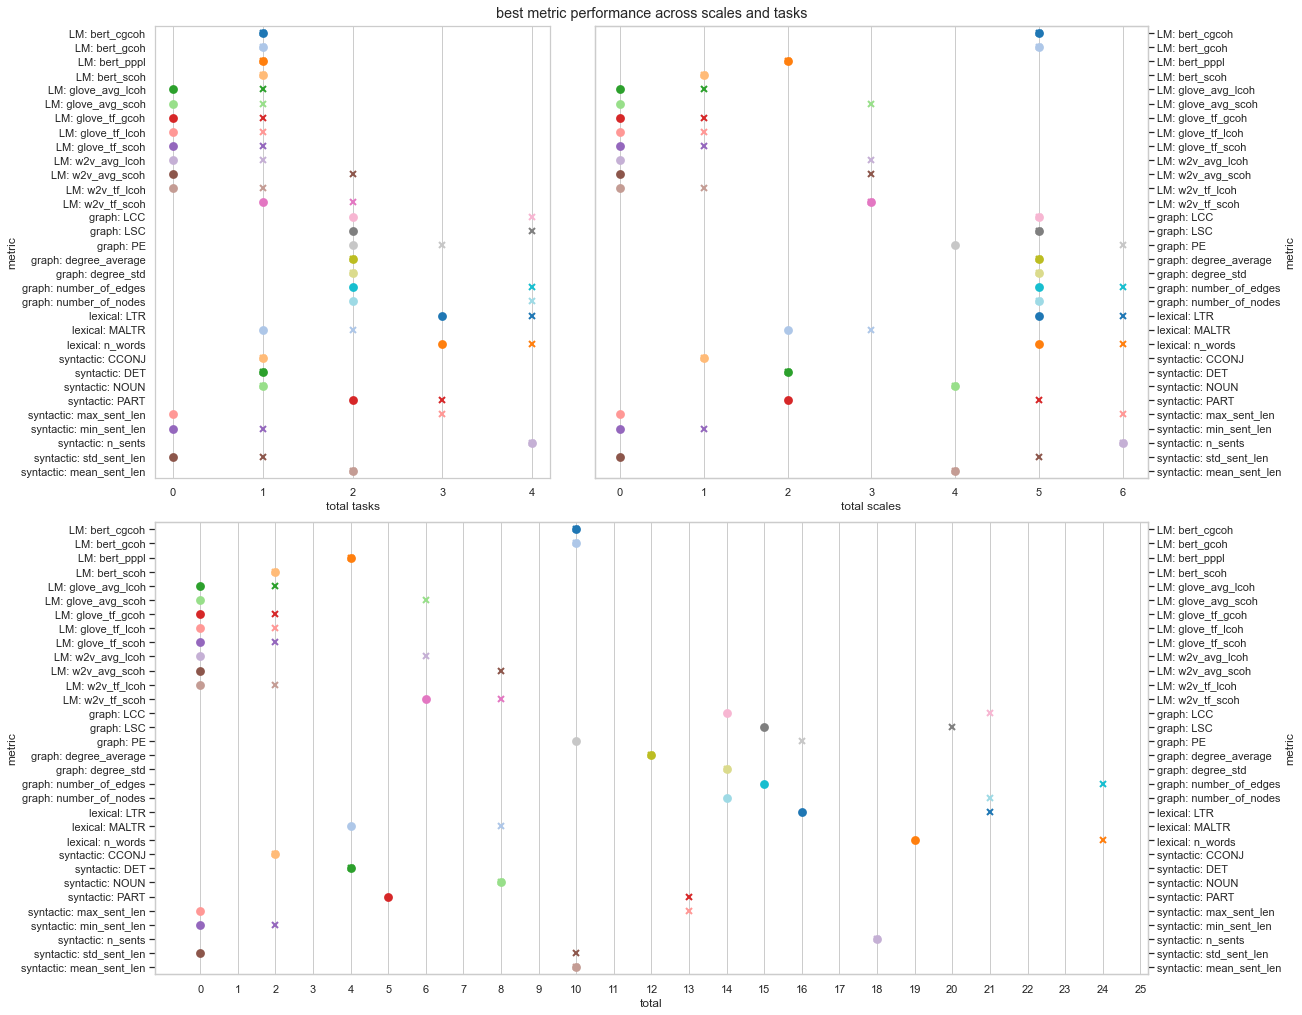

In [194]:
fig, axd = plt.subplot_mosaic([['left', 'right'],['bottom', 'bottom']],
                              constrained_layout=True, figsize=(18, 14),
                              width_ratios=[5/12, 7/12])
plt.suptitle('best metric performance across scales and tasks')

axd['left'].set_xticks(np.arange(5))
axd['left'].set_xlabel('total tasks')
d = metric_by_task(idxs_task_scale, idxs)
d_l = metric_by_task_w_corr_len(idxs_task_scale, idxs_bb_task_scale, idxs, idxs_bb_task)
for i in d_l.index:
    if i not in d.index:
        d.loc[i, 'total_tasks'] = 0 

d['metric'] = [': '.join(x) for x in d.index]
d_l['metric'] = [': '.join(x) for x in d_l.index]
pointplot_horizontal_wo_errorbar(d, x='total_tasks', ax=axd['left'], markers='o')
pointplot_horizontal_wo_errorbar(d_l, x='total_tasks', ax=axd['left'], markers='x')


axd['right'].set_xticks(np.arange(7))
axd['right'].set_yticks([])
axd['right'].set_xlabel('total scales')
d = metric_by_scale(idxs_scale, idxs_task_scale)
d_l = metric_by_scale_w_corr_len(idxs_scale, idxs_bb_scale, idxs_task_scale, idxs_bb_task_scale)
for i in d_l.index:
    if i not in d.index:
        d.loc[i, 'total_scales'] = 0 
        d.loc[i, 'total'] = 0 
d['metric'] = [': '.join(x) for x in d.index]
d_l['metric'] = [': '.join(x) for x in d_l.index]
ax2 = axd['right'].twinx()
pointplot_horizontal_wo_errorbar(d, x='total_scales', ax=ax2, markers='o')
pointplot_horizontal_wo_errorbar(d_l, x='total_scales', ax=ax2, markers='x')


axd['bottom'].set_xticks(np.arange(26))
pointplot_horizontal_wo_errorbar(d, x='total', ax=axd['bottom'], markers='o')
ax3 = axd['bottom'].twinx()
pointplot_horizontal_wo_errorbar(d_l, x='total', ax=ax3, markers='x')
plt.savefig(f'{PATH_FIG}/cross_task_compare_performance.png', dpi=150, bbox_inches = 'tight')

In [195]:
for i in d.index.levels[0]:
    print(i)
    for j in d.loc[i].index:
        print('\t', j)

LM
	 bert_cgcoh
	 bert_gcoh
	 bert_pppl
	 bert_scoh
	 w2v_tf_scoh
	 glove_avg_lcoh
	 glove_avg_scoh
	 glove_tf_gcoh
	 glove_tf_lcoh
	 glove_tf_scoh
	 w2v_avg_lcoh
	 w2v_avg_scoh
	 w2v_tf_lcoh
graph
	 LCC
	 LSC
	 PE
	 degree_average
	 degree_std
	 number_of_edges
	 number_of_nodes
lexical
	 LTR
	 MALTR
	 n_words
syntactic
	 CCONJ
	 DET
	 NOUN
	 PART
	 mean_sent_len
	 n_sents
	 max_sent_len
	 min_sent_len
	 std_sent_len


## Images for cross-metric comparison

In [196]:
def sort_index(idxs):
    ms = sorted(idxs)
    for s in ('syntactic: mean_sent_len', 'mean_sent_len', ('syntactic', 'mean_sent_len')):
        if s in ms:
            ms.remove(s)
            ms.append(s)
    return ms 

In [197]:
abs_med_df = median_bootstrap.applymap(abs)

In [198]:
panss_idx = [(task, scale, 'r') for task in TASKS for scale in panss_]
ord_idx = [(task, 'panss_total', scale) for task in TASKS for scale in ('ps_r_dep.severity', 'ps_r_td.severity')]
corr_len_idx = [(task, 'panss_total', 'r_corr_w_control') for task in TASKS]

In [199]:
mean_abs_corr_len = abs_med_df[corr_len_idx].apply(np.nanmean, axis=1)

In [200]:
mean_across_tasks = pd.DataFrame(index=abs_med_df.index)
for scale in panss_:
    mean_across_tasks[(scale, 'r')] = median_bootstrap[panss_idx].apply(lambda row: [row[task][scale]['r'] for task in TASKS], axis=1)
for scale in ('ps_r_dep.severity', 'ps_r_td.severity'):
    mean_across_tasks[('panss_total', scale)] = median_bootstrap[ord_idx].apply(lambda row: [row[task]['panss_total'][scale] for task in TASKS], axis=1)
mean_across_tasks.columns = pd.MultiIndex.from_tuples(mean_across_tasks.columns)

In [201]:
def add_len_lines_no_task(ax, df, scale, add_neg=True):
    if scale not in ('ps_r_dep.severity', 'ps_r_td.severity'): 
        median = np.median(df[scale].loc[('syntactic', 'mean_sent_len')]['r'])
    else:
        median = np.median(df['panss_total'].loc[('syntactic', 'mean_sent_len')][scale])
    ax.axvline(median, linestyle='--')
    if add_neg:
        ax.axvline(-median, linestyle='--')

In [202]:
def check_m(m, scale, scales_df, mean_abs_corr_len, r=0.3, rc=0.3):
    if scale not in ('ps_r_dep.severity', 'ps_r_td.severity'): 
        median = np.median(scales_df[scale].loc[m]['r'])
    else:
        median = np.median(scales_df['panss_total'].loc[m][scale])
    ok_corr = mean_abs_corr_len.loc[m] < rc
    mr = abs(median) 
    ok_scale = mr > r
    return ok_corr and ok_scale

In [203]:
def plot_subplot(ax, measure, scale, mean_across_tasks, mean_abs_corr_len, idxs, plot_abs=False, ax_share=None):
    if abs(np.nanmean(mean_across_tasks[scale].loc[('syntactic', 'mean_sent_len')]['r'])) > 0.3:
        add_len_lines_no_task(ax, mean_across_tasks, scale)
    markers = ['o' if check_m(m, scale, mean_across_tasks, mean_abs_corr_len) else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(mean_across_tasks[scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=ax, markers=markers, estimator='mean', errorbar="sd")
    ax.set_title(f'{measure} {scale}')
    if ax_share:
        ax.sharex(ax_share)

In [204]:
fig, axes = plt.subplots(3, 2, figsize=(18, 22))
fig.suptitle(f'cross-scale cross-type metric comparison averaged across tasks', y=0.9)
plt.subplots_adjust(hspace=0.15) 
plt.subplots_adjust(wspace=0.4) 
ms = sorted(list(set([y for x in idxs_scale.values() for y in x] + [y for x in idxs_bb_scale.values() for y in x])))

idxs_ = sort_index(ms)

measure = 'r'
plot_abs = False

axs = axes.flatten()
for i, scale in enumerate(panss_order):
    ax = axs[i]
    plot_subplot(ax, measure, scale, mean_across_tasks, mean_abs_corr_len, idxs_)

add_grey(axes[:2, :])

scale = 'ps_r_td.severity'
ax = axes[2, 0]
if abs(np.nanmean(mean_across_tasks['panss_total'].loc[('syntactic', 'mean_sent_len')][scale])) > 0.09:
    add_len_lines_no_task(ax, mean_across_tasks, scale)
markers = ['o' if check_m(m, scale, mean_across_tasks, mean_abs_corr_len, r=0.09) else 'x' for m in idxs_]
d = prep_horizontal_pointplot_errobar_data(mean_across_tasks['panss_total'].loc[idxs_], 'ps_r_td.severity')
pointplot_horizontal(d, x='ps_r_td.severity', ax=ax, markers=markers, estimator='mean', errorbar="sd")
ax.set_xlabel('pseudo r squared')
ax.set_title(f'td severity')

scale = 'ps_r_dep.severity'
ax = axes[2, 1]
if abs(np.nanmean(mean_across_tasks['panss_total'].loc[('syntactic', 'mean_sent_len')][scale])) > 0.09:
    add_len_lines_no_task(ax, mean_across_tasks, scale)
markers = ['o' if check_m(m, scale, mean_across_tasks, mean_abs_corr_len, r=0.09) else 'x' for m in idxs_]
d = prep_horizontal_pointplot_errobar_data(mean_across_tasks['panss_total'].loc[idxs_], 'ps_r_dep.severity')
pointplot_horizontal(d, x='ps_r_dep.severity', ax=ax, markers=markers, estimator='mean', errorbar="sd")
ax.set_xlabel('pseudo r squared')
ax.set_title(f'dep severity')
ax.sharex(axes[2, 0])
add_grey(axes[2, :], r=0.09)

plt.savefig(f'{PATH_FIG}/cross_task_average_compare_r.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

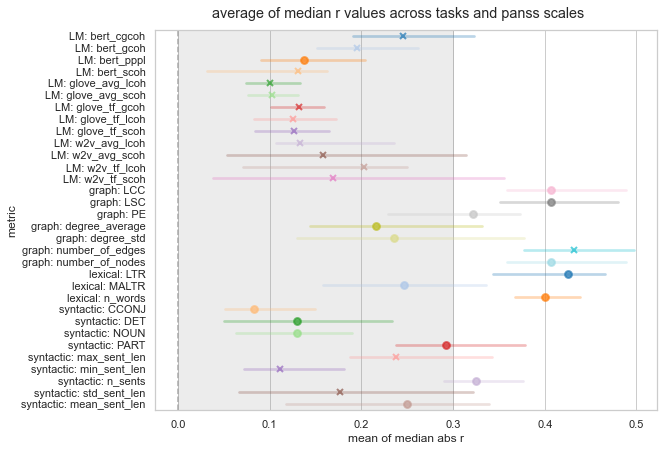

In [205]:
ms = sorted(list(set([y for x in idxs_scale.values() for y in x] + [y for x in idxs_bb_scale.values() for y in x])))
markers = ['o' if pd.isna(mean_abs_corr_len[m]) or mean_abs_corr_len[m] <= 0.3 else 'x' for m in sort_index(ms)]
median_asb_r = pd.DataFrame(abs_med_df.loc[ms][panss_idx].apply(lambda x: x.to_list(), axis=1), columns=['mean of median abs r'])

d = prep_horizontal_pointplot_errobar_data(median_asb_r, 'mean of median abs r')
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
pointplot_horizontal(d, 'mean of median abs r', ax, markers=markers)
add_grey(ax)
fig.suptitle('average of median r values across tasks and panss scales', y=0.925);
plt.savefig(f'{PATH_FIG}/cross_task_compare_r.png', dpi=150, bbox_inches = 'tight')

In [206]:
len(ms)

32

In [207]:
len(set([y for x in idxs_scale.values() for y in x]))

21

### For each scale

In [208]:
def add_control_lines(ax, df, task, scale, control_col=('syntactic', 'mean_sent_len'), add_neg=True):
    if scale not in ('ps_r_dep.severity', 'ps_r_td.severity'): 
        median = np.median(df[task][scale].loc[control_col]['r'])
    else:
        median = np.median(df[task]['panss_total'].loc[control_col][scale])
    ax.axvline(median, linestyle='--')
    if add_neg:
        ax.axvline(-median, linestyle='--')

In [209]:
def add_len_lines(ax, df, task, scale, add_neg=True):
    if scale not in ('ps_r_dep.severity', 'ps_r_td.severity'): 
        median = np.median(df[task][scale].loc[('syntactic', 'mean_sent_len')]['r'])
    else:
        median = np.median(df[task]['panss_total'].loc[('syntactic', 'mean_sent_len')][scale])
    ax.axvline(median, linestyle='--')
    if add_neg:
        ax.axvline(-median, linestyle='--')

In [210]:
def plot_one_scale_for_all_tasks_across_best_metrics(df, idxs, idxs_task_scale, scale, 
                                                     measure='r', plot_abs=False, r=0.3, title=None,
                                                     xname=None, figsize=(18, 6),
                                                     add_neg=True):
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=True)
    tit_scale = scale if measure == 'r' else measure
    if title is None:
        title=f'cross-task cross-type metric comparison for {tit_scale}'
    fig.suptitle(title, y=0.95)
    plt.subplots_adjust(wspace=0.4, hspace=0.1) #left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

    idxs = sort_index(idxs)
    
    axs = axes.flatten()
    for i, task in enumerate(TASKS):
        ax = axs[i]
        if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][tit_scale]:
            add_len_lines(ax, df, task, tit_scale, add_neg=add_neg)
        markers = ['o' if m in idxs_task_scale[task][tit_scale] else 'x' for m in idxs]
        d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
        pointplot_horizontal(d, x=measure, ax=ax, markers=markers)
        ax.set_title(task)
    add_grey(axes, r=r)
    
    
    if xname is None:
        xname = measure
    
    for ax in axes.reshape(-1): 
        label = 'abs ' + xname if plot_abs else xname
        ax.set_xlabel(label)
    
    return fig
    # plt.savefig(f'{PATH_FIG}/compare_r.png', dpi=150, bbox_inches = 'tight')

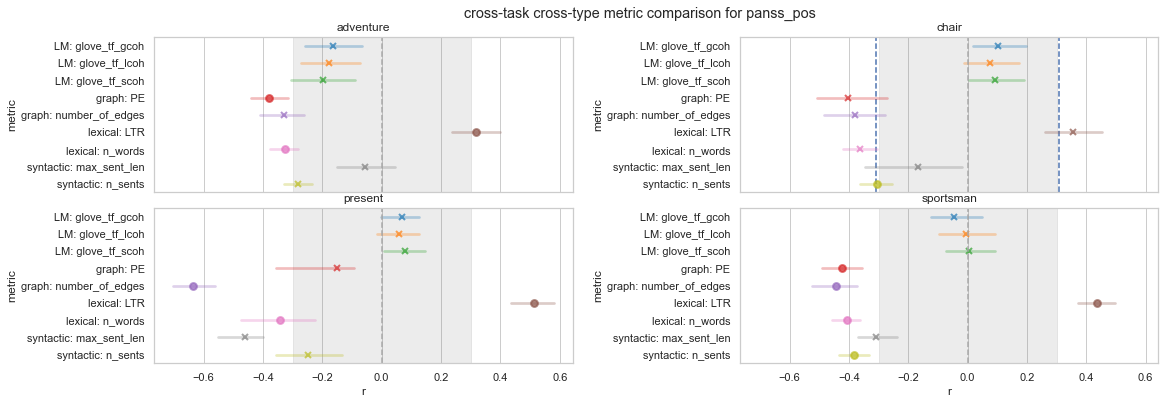

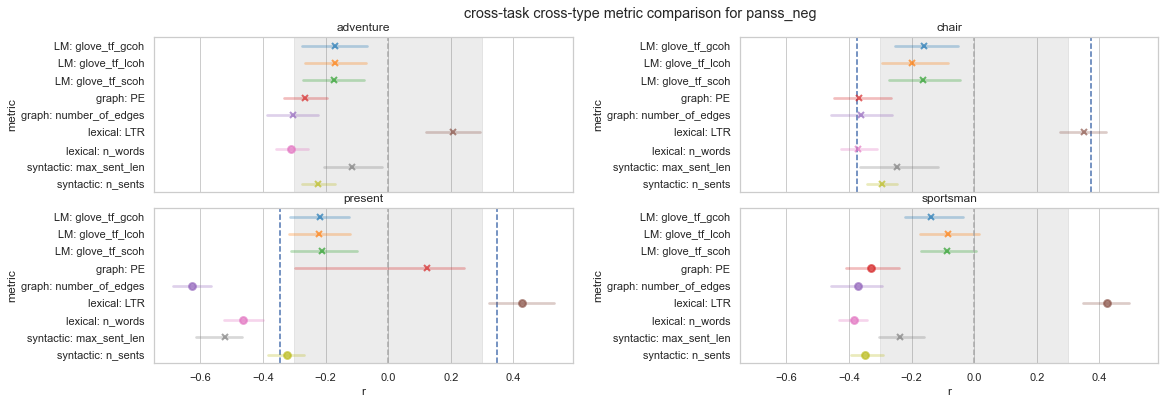

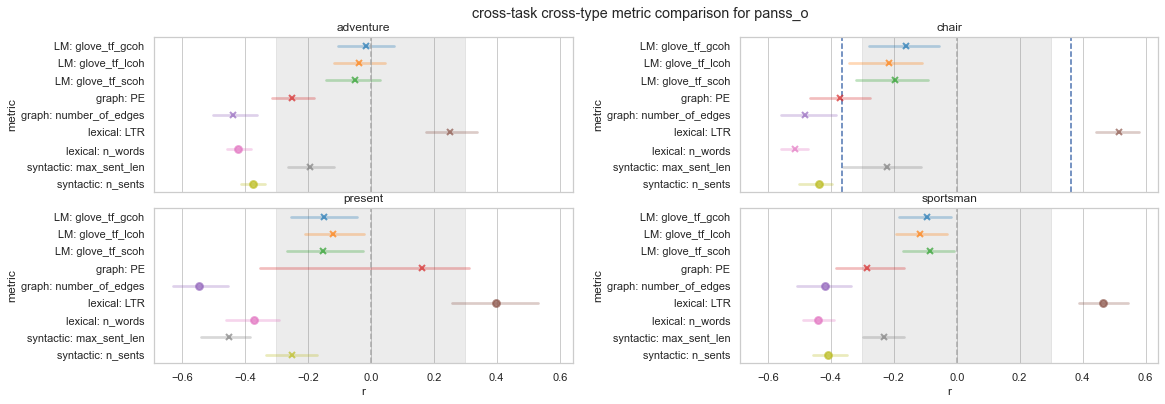

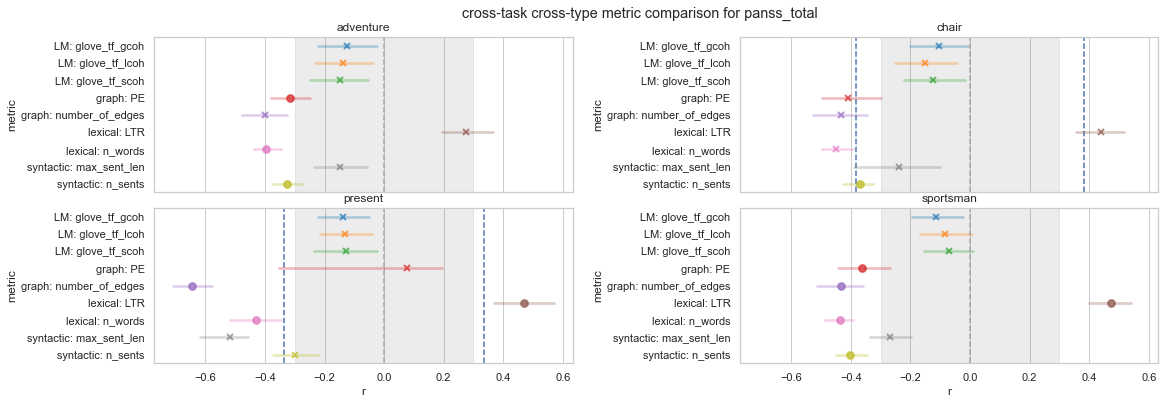

In [211]:
for p_scale in panss_:
    fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, 
                                                           set(idxs_scale[scale] + idxs_bb_scale[scale]), 
                                                           idxs_task_scale, scale=p_scale)
#     plt.savefig(f'{PATH_FIG}/compare_{p_scale}.png', dpi=150, bbox_inches = 'tight')
#     plt.close(fig)

In [212]:
fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, 
                                                       set(idxs_scale['ps_r_dep.severity'] 
                                                           + idxs_bb_scale['ps_r_dep.severity']), 
                                                       idxs_task_scale, 
                                                     scale='panss_pos', measure='ps_r_dep.severity', r=0.09, 
                                                     title='cross-task cross-type metric comparison for dep severity',
                                                     xname='pseudo r squared', add_neg=False)
plt.savefig(f'{PATH_FIG}/compare_dep_severity.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [213]:
fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, 
                                                       set(idxs_scale['ps_r_td.severity']
                                                           + idxs_bb_scale['ps_r_td.severity']),
                                                       idxs_task_scale, scale='panss_pos', 
                                                       measure='ps_r_td.severity', r=0.09, 
                                                       title='cross-task cross-type metric comparison for td severity',
                                                       xname='pseudo r squared', add_neg=False)
plt.savefig(f'{PATH_FIG}/compare_td_severity.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

In [214]:
fig = plot_one_scale_for_all_tasks_across_best_metrics(reformed_d, bad_ms, 
                                                       {t: {'r_corr_w_control': idxs_corr_len[t]} for t in idxs_corr_len}, 
                                                         scale='panss_pos', measure='r_corr_w_control', 
                                                         title='cross-task cross-type metric comparison for correlation with mean sent len',
                                                         xname='r', figsize=(20, 20))
plt.savefig(f'{PATH_FIG}/compare_corr_len.png', dpi=150, bbox_inches = 'tight')
plt.close(fig)

### best across tasks

In [215]:
def plot_all_scales_for_task_across_best_metrics(df, idxs, idxs_task_scale, task, 
                                                 measure='r', plot_abs=False, figsize=(18, 8), use_markers=True):
    absolute_value = f' (absolute r value)' if plot_abs else ''
    ab = 'abs ' if plot_abs else ''
    fig, axes = plt.subplots(3, 2, figsize=figsize)
    fig.suptitle(f'cross-scale cross-type metric comparison {absolute_value} for {task} task', y=0.925)
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    
    idxs = sort_index(idxs)
    
    scale = 'panss_pos'
    if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][scale]:
        add_len_lines(axes[0, 0], df, task, scale)
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 0], markers=markers if use_markers else 'o')
    axes[0, 0].set_title(f'{ab}{measure} {scale}')

    scale = 'panss_neg'
    if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][scale]:
        add_len_lines(axes[0, 1], df, task, scale)
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[0, 1], markers=markers if use_markers else 'o')
    axes[0, 1].set_title(f'{ab}{measure} {scale}')
    axes[0, 1].sharex(axes[0, 0])

    scale = 'panss_o'
    if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][scale]:
        add_len_lines(axes[1, 0], df, task, scale)
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 0], markers=markers if use_markers else 'o')
    axes[1, 0].set_title(f'{ab}{measure} {scale}')
    axes[1, 0].sharex(axes[0, 0])

    scale = 'panss_total'
    if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][scale]:
        add_len_lines(axes[1, 1], df, task, scale)
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task][scale].loc[idxs], measure, plot_abs=plot_abs)
    pointplot_horizontal(d, x=measure, ax=axes[1, 1], markers=markers if use_markers else 'o')
    axes[1, 1].set_title(f'{ab}{measure} {scale}')
    axes[1, 1].sharex(axes[0, 0])
    add_grey(axes[:2, :])
    
    if plot_abs:
        for ax in axes[:2, :].reshape(-1): 
            ax.set_xlabel('abs ' + measure);

    scale = 'ps_r_td.severity'
    if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][scale]:
        add_len_lines(axes[2, 0], df, task, scale, add_neg=False)
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task]['panss_total'].loc[idxs], 'ps_r_td.severity')
    pointplot_horizontal(d, x='ps_r_td.severity', ax=axes[2, 0], markers=markers if use_markers else 'o')
    axes[2, 0].set_xlabel('pseudo r squared');
    axes[2, 0].set_title(f'td severity')

    scale = 'ps_r_dep.severity'
    if ('syntactic', 'mean_sent_len') in idxs_task_scale[task][scale]:
        add_len_lines(axes[2, 1], df, task, scale, add_neg=False)
    markers = ['o' if m in idxs_task_scale[task][scale] else 'x' for m in idxs]
    d = prep_horizontal_pointplot_errobar_data(df[task]['panss_total'].loc[idxs], 'ps_r_dep.severity')
    pointplot_horizontal(d, x='ps_r_dep.severity', ax=axes[2, 1], markers=markers if use_markers else 'o')
    axes[2, 1].set_xlabel('pseudo r squared');
    axes[2, 1].set_title(f'dep severity')
    axes[2, 1].sharex(axes[2, 0])
    add_grey(axes[2, :], r=0.09)
    
    return fig

In [216]:
figsizes = {
    'adventure': (18, 8),
    'chair': (18, 13),
    'present': (18, 15),
    'sportsman': (18, 10),
}
for task in TASKS:
    fig = plot_all_scales_for_task_across_best_metrics(reformed_d, 
                                                       set(idxs[task]).union(idxs_bb_task[task]),
                                                       idxs_task_scale, task, figsize=figsizes[task])
    plt.savefig(f'{PATH_FIG}/compare_{task}.png', dpi=150, bbox_inches = 'tight')
    plt.close(fig)

### T-test

In [217]:
def select_ok_metrics_t(row, low=0.25, high=0.75):
    q_low = np.quantile(row['panss_total', 't'], low)
    q_high = np.quantile(row['panss_total', 't'], high)
    return q_low > 0 or q_high < 0

In [218]:
reformed_d['chair'][reformed_d['chair'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

In [219]:
reformed_d['adventure'][reformed_d['adventure'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

In [220]:
reformed_d['sportsman'][reformed_d['sportsman'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

In [221]:
reformed_d['present'][reformed_d['present'].apply(select_ok_metrics_t, axis=1)].index

MultiIndex([], )

### average LM model / metric performance medians across scales

In [222]:
def mean_model_metric_medians(median_df, tsk, leave_out=()):
    resp_d_model = pd.DataFrame(columns=[f'{sc} abs r' for sc in panss_] + list(sc_ind_), index=models_)
    resp_d_metric = pd.DataFrame(columns=[f'{sc} abs r' for sc in panss_] + list(sc_ind_), index=metrics_)
    for scale in panss_:
        ex_d = prep_LM_pointplot(median_df.loc['LM', (tsk, scale)], col='r', use_errorbar=False, plot_abs=True)
        if leave_out:
                leave_out_ = ex_d.drop(ex_d[ex_d['metric'].isin(leave_out)].index)
        for model in models_:
            if leave_out:
                resp_d_model.loc[model, f'{scale} abs r'] = np.nanmean(leave_out_[leave_out_['model'] == model]['r'])
            else:
                resp_d_model.loc[model, f'{scale} abs r'] = np.nanmean(ex_d[ex_d['model'] == model]['r'])
        for metric in metrics_:
            resp_d_metric.loc[metric, f'{scale} abs r'] = np.nanmean(ex_d[ex_d['metric'] == metric]['r'])
    for sc_ind in sc_ind_:
        if leave_out:
                leave_out_ = ex_d.drop(ex_d[ex_d['metric'].isin(leave_out)].index)
        for model in models_:
            if leave_out:
                resp_d_model.loc[model, sc_ind] = np.nanmean(leave_out_[leave_out_['model'] == model][sc_ind])
            else:
                resp_d_model.loc[model, sc_ind] = np.nanmean(ex_d[ex_d['model'] == model][sc_ind])
        for metric in metrics_:
            resp_d_metric.loc[metric, sc_ind] = np.nanmean(ex_d[ex_d['metric'] == metric][sc_ind])
    return resp_d_model, resp_d_metric

#### only including cosine-similarity based metrics

In [223]:
dfs_model = []
dfs_metric = []

for task in TASKS:
    resp_d_model, resp_d_metric = mean_model_metric_medians(median_bootstrap, task, leave_out=('sprob', 'pppl'))
    dfs_model.append(resp_d_model)
    dfs_metric.append(resp_d_metric)
    
df_model = pd.concat(dfs_model, keys=TASKS, names=['task'], axis=1)
df_metric = pd.concat(dfs_metric, keys=TASKS, names=['task'], axis=1)

In [224]:
style(df_model['sportsman'])

,panss_pos abs r,panss_neg abs r,panss_o abs r,panss_total abs r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
bert,0.162187,0.156510,0.169223,0.173754,0.513164,0.373948,0.016427,0.020755
glove_tf,0.018632,0.104372,0.088828,0.087441,0.041688,0.500101,0.016616,0.012458
glove_avg,0.106723,0.040614,0.050345,0.042436,0.054562,0.628015,0.023785,0.015005
w2v_tf,0.096123,0.108970,0.096841,0.098505,0.184227,0.711080,0.031798,0.013529
w2v_avg,0.090773,0.077277,0.090087,0.080255,0.137622,0.744135,0.022216,0.019192


In [225]:
df_corr_len = pd.DataFrame()
for task in TASKS:
    df_corr_len[task] = df_model[task]['r_corr_w_control']
df_corr_len['mean'] = df_corr_len.apply(np.nanmean, axis=1)
style(df_corr_len)

,adventure,chair,present,sportsman,mean
bert,0.337579,0.488510,0.253576,0.373948,0.363403
glove_tf,0.388105,0.392268,0.263819,0.500101,0.386073
glove_avg,0.368215,0.189773,0.442847,0.628015,0.407212
w2v_tf,0.465053,0.452374,0.381337,0.711080,0.502461
w2v_avg,0.593667,0.569552,0.531674,0.744135,0.609757


In [226]:
df_corr_len['mean'].sort_values()

bert         0.363403
glove_tf     0.386073
glove_avg    0.407212
w2v_tf       0.502461
w2v_avg      0.609757
Name: mean, dtype: float64

In [227]:
df_corr_sym = pd.DataFrame()
for task in TASKS:
    copy_ = df_model[task][['panss_pos abs r', 'panss_neg abs r', 'panss_o abs r','panss_total abs r']].copy()
    copy_['ps_r_dep.severity'] = df_model[task]['ps_r_dep.severity'] ** 0.5
    copy_['ps_r_td.severity'] = df_model[task]['ps_r_td.severity'] ** 0.5
    df_corr_sym[task] = copy_[['panss_pos abs r', 'panss_neg abs r', 'panss_o abs r','panss_total abs r',
                               'ps_r_dep.severity', 'ps_r_td.severity']].mean(axis=1)

df_corr_sym['mean'] = df_corr_sym.apply(np.nanmean, axis=1)
style(df_corr_sym)

,adventure,chair,present,sportsman,mean
bert,0.109937,0.137969,0.317885,0.155651,0.180361
glove_tf,0.122171,0.167498,0.131017,0.089965,0.127663
glove_avg,0.085712,0.133443,0.202681,0.086139,0.126994
w2v_tf,0.166935,0.140056,0.195729,0.115845,0.154641
w2v_avg,0.148134,0.129196,0.211592,0.104330,0.148313


In [228]:
df_corr_sym['mean'].sort_values()

glove_avg    0.126994
glove_tf     0.127663
w2v_avg      0.148313
w2v_tf       0.154641
bert         0.180361
Name: mean, dtype: float64

In [229]:
style(df_metric['sportsman'])

,panss_pos abs r,panss_neg abs r,panss_o abs r,panss_total abs r,t,r_corr_w_control,ps_r_dep.severity,ps_r_td.severity
cgcoh,0.183196,0.116198,0.119935,0.142023,0.346000,0.568952,0.017241,0.024013
gcoh,0.074448,0.110492,0.082811,0.088487,0.144488,0.630541,0.019156,0.015445
lcoh,0.060411,0.102516,0.112975,0.100362,0.150293,0.559417,0.032537,0.012190
scoh,0.061496,0.060989,0.080538,0.055040,0.104229,0.606914,0.019740,0.013102
sprob,0.110585,0.204950,0.285809,0.226406,0.120900,0.153455,0.025500,0.025189
pppl,0.040897,0.097839,0.070937,0.031355,0.095336,0.076592,0.033634,0.032495


#### including feature based metrics for BERT

In [230]:
dfs_model = []
dfs_metric = []

for task in TASKS:
    resp_d_model, resp_d_metric = mean_model_metric_medians(median_bootstrap, task)
    dfs_model.append(resp_d_model)
    dfs_metric.append(resp_d_metric)
    
df_model = pd.concat(dfs_model, keys=TASKS, names=['task'], axis=1)
df_metric = pd.concat(dfs_metric, keys=TASKS, names=['task'], axis=1)

In [231]:
df_corr_sym = pd.DataFrame()
for task in TASKS:
    copy_ = df_model[task][['panss_pos abs r', 'panss_neg abs r', 'panss_o abs r','panss_total abs r']].copy()
    copy_['ps_r_dep.severity'] = df_model[task]['ps_r_dep.severity'] ** 0.5
    copy_['ps_r_td.severity'] = df_model[task]['ps_r_td.severity'] ** 0.5
    df_corr_sym[task] = copy_[['panss_pos abs r', 'panss_neg abs r', 'panss_o abs r','panss_total abs r',
                               'ps_r_dep.severity', 'ps_r_td.severity']].mean(axis=1)

df_corr_sym['mean'] = df_corr_sym.apply(np.nanmean, axis=1)
style(df_corr_sym)

,adventure,chair,present,sportsman,mean
bert,0.123741,0.133444,0.268742,0.152771,0.169675
glove_tf,0.122171,0.167498,0.131017,0.089965,0.127663
glove_avg,0.085712,0.133443,0.202681,0.086139,0.126994
w2v_tf,0.166935,0.140056,0.195729,0.115845,0.154641
w2v_avg,0.148134,0.129196,0.211592,0.104330,0.148313


In [232]:
df_corr_len = pd.DataFrame()
for task in TASKS:
    df_corr_len[task] = df_model[task]['r_corr_w_control']
df_corr_len['mean'] = df_corr_len.apply(np.nanmean, axis=1)
style(df_corr_len)

,adventure,chair,present,sportsman,mean
bert,0.264342,0.340279,0.184482,0.287640,0.269186
glove_tf,0.388105,0.392268,0.263819,0.500101,0.386073
glove_avg,0.368215,0.189773,0.442847,0.628015,0.407212
w2v_tf,0.465053,0.452374,0.381337,0.711080,0.502461
w2v_avg,0.593667,0.569552,0.531674,0.744135,0.609757


In [233]:
df_corr_len['mean'].sort_values()

bert         0.269186
glove_tf     0.386073
glove_avg    0.407212
w2v_tf       0.502461
w2v_avg      0.609757
Name: mean, dtype: float64

# Reform the dataset to long format

index: unique

langugae: de / ru

task: (de tasks) / (ru tasks) - 4 for each

scale: (de: panss sans saps t test) / (ru: panss dep td t test)

metric: name

matric_group: 4

values: median CI_low CI_high corr_mean_sent_len corr_n_sent corr_n_word

In [32]:
control_corr_names = ['r_corr_w_mean_sent_len', 'r_corr_w_n_sents', 'r_corr_w_n_words']

In [33]:
low = 0.25
high = 0.75
lang = 'ru'

In [42]:
sc_ind_

('t', 'r_corr_w_control', 'ps_r_dep.severity', 'ps_r_td.severity')

In [45]:
long_data = []
for task in TASKS:
    for scale_ in panss_order + ['group_diff', 'sample_raw', 'ps_r_dep.severity', 'ps_r_td.severity']:
        performance_metric_d = {'sample_raw': 'sample_raw', 'group_diff': 't'}
        performance_metric = 'r' if scale_ not in performance_metric_d else performance_metric_d[scale_] 
        scale_key = 'panss_total' if scale_ not in panss_order else scale_
        for metric in cols_tasks:
            metric_group, metric_name = metric
            data = reformed_d_w_verbosity[(task, scale_key, performance_metric)][(metric_group, metric_name)]
            median = np.nanmedian(data)
            mean = np.nanmean(data)
            CI_low = np.nanquantile(np.array(data), low)
            CI_high = np.nanquantile(np.array(data), high)
#             if np.isnan(median):
#                 print('nan median in: ', task, scale_, performance_metric, metric_group, metric_name)
#             line = (lang, task, scale_, metric_name)
            control_cols_medians, control_cols_means, control_cols_CI_lows, control_cols_CI_highs = {}, {}, {}, {}
            for control_col in control_corr_names:
                control_data = reformed_d_w_verbosity[(task, scale_key, control_col)][metric]
                if control_data[0]:
                    c_median = np.nanmedian(control_data)
                    c_mean = np.nanmean(control_data)
                    c_CI_low = np.nanquantile(np.array(control_data), low)
                    c_CI_high = np.nanquantile(np.array(control_data), high)
                else:
                    c_median, c_mean, c_CI_high, c_CI_low = np.nan, np.nan, np.nan, np.nan
                control_cols_medians[control_col] = c_median
                control_cols_means[control_col] = c_mean
                control_cols_CI_lows[control_col] = c_CI_low
                control_cols_CI_highs[control_col] = c_CI_high
            performance_metric_to_write = {'ps_r_dep.severity': 'ps_r', 'ps_r_td.severity': 'ps_r'}[scale_] \
                if scale_ in {'ps_r_dep.severity', 'ps_r_td.severity'} else performance_metric
            long_line = (lang, task, scale_, performance_metric_to_write, metric_group, metric_name, 
                         median, mean, CI_low, CI_high)
            for control_col in control_corr_names:
                long_line += (control_cols_medians[control_col], control_cols_means[control_col], 
                              control_cols_CI_lows[control_col], control_cols_CI_highs[control_col])
            if long_line not in long_data:
                long_data.append(long_line)
            else:
                print(line)

In [46]:
long_df = pd.DataFrame(long_data, columns=('lang', 'task', 'scale', 'performance_metric',
                                           'metric_group', 'metric_name', 'median', 'mean', 'CI_low', 'CI_high',
                                           'corr_mean_sent_len_median', 'corr_mean_sent_len_mean', 
                                           'corr_mean_sent_len_CI_low', 'corr_mean_sent_len_CI_high',
                                           'corr_n_sents_median', 'corr_n_sents_mean',
                                           'corr_n_sents_CI_low', 'corr_n_sents_CI_high',
                                           'corr_n_words_median', 'corr_n_words_mean',
                                           'corr_n_words_CI_low', 'corr_n_words_CI_high',))
long_df.head()

,lang,task,scale,performance_metric,metric_group,metric_name,median,mean,CI_low,CI_high,...,corr_mean_sent_len_CI_low,corr_mean_sent_len_CI_high,corr_n_sents_median,corr_n_sents_mean,corr_n_sents_CI_low,corr_n_sents_CI_high,corr_n_words_median,corr_n_words_mean,corr_n_words_CI_low,corr_n_words_CI_high
0,ru,adventure,panss_pos,r,LM,bert_cgcoh,0.200847,0.189505,0.067264,0.311966,...,-0.364096,-0.210042,-0.069433,-0.068849,-0.126091,-0.011413,-0.174769,-0.175428,-0.236354,-0.115546
1,ru,adventure,panss_pos,r,LM,bert_gcoh,0.154398,0.148511,0.015530,0.282842,...,-0.387907,-0.224763,-0.006654,-0.004452,-0.062194,0.050718,-0.108034,-0.109928,-0.163946,-0.055229
2,ru,adventure,panss_pos,r,LM,bert_lcoh,0.070749,0.069871,-0.042110,0.185818,...,-0.531590,-0.358070,0.056118,0.055704,0.006082,0.110794,-0.088285,-0.091741,-0.138126,-0.041677
3,ru,adventure,panss_pos,r,LM,bert_pppl,-0.046313,-0.046096,-0.180025,0.079663,...,-0.161571,-0.049485,0.028740,0.033730,-0.015126,0.077491,-0.020944,-0.014051,-0.062853,0.029371
4,ru,adventure,panss_pos,r,LM,bert_scoh,0.031614,0.034653,-0.080064,0.156002,...,-0.370074,-0.214460,0.058171,0.056851,0.002641,0.112803,-0.033667,-0.037100,-0.093653,0.021272


In [48]:
long_df.scale.unique()

array(['panss_pos', 'panss_neg', 'panss_o', 'panss_total', 'group_diff',
       'sample_raw', 'ps_r_dep.severity', 'ps_r_td.severity'],
      dtype=object)

In [49]:
long_df.performance_metric.unique()

array(['r', 't', 'sample_raw', 'ps_r'], dtype=object)

In [50]:
long_df[long_df[['lang', 'task', 'scale', 'metric_group', 'metric_name']].duplicated(keep=False)]

,lang,task,scale,performance_metric,metric_group,metric_name,median,mean,CI_low,CI_high,...,corr_mean_sent_len_CI_low,corr_mean_sent_len_CI_high,corr_n_sents_median,corr_n_sents_mean,corr_n_sents_CI_low,corr_n_sents_CI_high,corr_n_words_median,corr_n_words_mean,corr_n_words_CI_low,corr_n_words_CI_high


In [51]:
long_df.to_csv(PATH + '/processed_values/long_ru.csv')